# Machine Learning and Statistics for Physicists

Material for a [UC Irvine](https://uci.edu/) course offered by the [Department of Physics and Astronomy](https://www.physics.uci.edu/).

Content is maintained on [github](github.com/dkirkby/MachineLearningStatistics) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

[Table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
from sklearn import preprocessing, pipeline, model_selection, linear_model

In [3]:
import tensorflow as tf

In [4]:
import edward as ed
import edward.models

In [5]:
from mls import cv_summary, create_param_grid, estimate_log_evidence

## Model Selection With Cross Validation

Recall that there are three main types of learning:
 - Learning model parameters from data.
 - Learning to predict new data (unsupervised learning).
 - Learning to predict target features in new data (supervised learning).
 
All three types of learning require an assumed model with associated parameters, and predicting new data is only possible after learning model parameters from old data.

Since all types of learning assume a model, they must all solve the meta-problem of comparing competing models. The Bayesian evidence $P(D\mid M)$ is our primary quantitative tool for comparing how well different models explain the same data.  When we are primarily interested in a model's ability to generalize and predict new data, **cross validation** is a useful alternative.

The basic idea of cross validation is to:
 - split the observed data into separate training and test datasets,
 - learn the model from the training dataset,
 - measure the model's ability to predict the test dataset, and
 - repeat the steps above with different splits and combine the results.

Comparing with the Bayesian evidence, cross validation:
 - is generally much easier to implement,
 - has less statistical power because the data must be split, and
 - does not account for priors on models or model parameters.

### Overfitting and Generalization

Generate some data consisting of 2D points along the path of a projectile, where $x$ is measured with negligible error and $y$ has a known error $\sigma_y$:

In [6]:
xlo, xhi = 0., 1.
poly_coefs = np.array([-1., 2., -1.])
f = lambda X: np.dot(poly_coefs, [X ** 0, X ** 1, X ** 2])
sigma_y = 0.2

In [7]:
def generate(N, seed=123):
    gen = np.random.RandomState(seed=seed)
    X = gen.uniform(xlo, xhi, size=N)
    y = f(X) + gen.normal(scale=sigma_y, size=N)
    return X, y

Compare results with different numbers of samples from the same model:

In [8]:
Xa, ya = generate(N=15)
Xb, yb = generate(N=150)

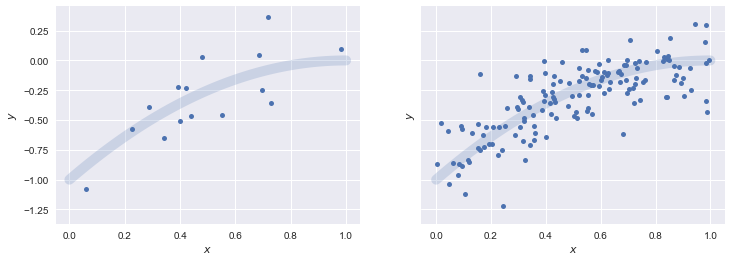

In [9]:
def plotXy(X, y, ax=None, *fits):
    ax = ax or plt.gca()
    ax.scatter(X, y, s=25, lw=0)
    x_grid = np.linspace(xlo, xhi, 100)
    ax.plot(x_grid, f(np.array(x_grid)), '-', lw=10, alpha=0.2)
    for fit in fits:
        y_fit = fit.predict(x_grid.reshape(-1, 1))
        ax.plot(x_grid, y_fit, lw=2, alpha=1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ylo, yhi = np.percentile(y, (0, 100))
    dy = yhi - ylo
    ax.set_ylim(ylo - 0.1 * dy, yhi + 0.1 * dy)
    
_, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
plotXy(Xa, ya, ax[0])
plotXy(Xb, yb, ax[1])

The family of competing models we consider are polynomials of different degrees $P$,
$$
y(x) = \sum_{k=0}^P\, c_k x^k \; ,
$$
each with $P+1$ parameters.  The true model that the datasets were generated from have $P=2$.

Use sklearn [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to implement this fit after expanding the features with [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html),
$$
x \; \rightarrow\; \{ x^0, x^1, \ldots, x^P \} \; ,
$$
and combining the preprocessing and regression steps into a [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html):

In [10]:
def poly_fit(X, y, degree):
    degree_is_zero = (degree == 0)
    model = pipeline.Pipeline([
        ('poly', preprocessing.PolynomialFeatures(degree=degree, include_bias=degree_is_zero)),
        ('linear', linear_model.LinearRegression(fit_intercept=not degree_is_zero))])
    return model.fit(X.reshape(-1, 1), y)

Compare fits with $P = 0, 1, 2, 14$ to each dataset. Note that $P=14$ is an extreme case of overfitting to the smaller dataset, with the model passing exactly through each sample with large oscillations between them.  Similarly, $P=1$ underfits the larger dataset:

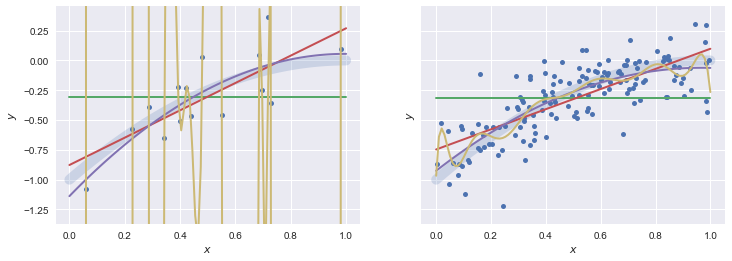

In [11]:
_, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
plotXy(Xa, ya, ax[0], poly_fit(Xa, ya, 0), poly_fit(Xa, ya, 1), poly_fit(Xa, ya, 2), poly_fit(Xa, ya, 14))
plotXy(Xb, yb, ax[1], poly_fit(Xb, yb, 0), poly_fit(Xb, yb, 1), poly_fit(Xb, yb, 2), poly_fit(Xb, yb, 14))

### The Train-Test Split

The [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function picks a random fraction of the observed data to hold back when learning the model and then use for latest testing.

Note that since train/test splitting involves random numbers, you will need to pass around a random state object for reproducible results.

The plots below show 20% of the data reserved for testing (red points) with a $P=2$ fit to the training data superimposed. The primary sklearn test metric for regression problems is the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) $R^2$, for which the goal is $R^2 = 1$:

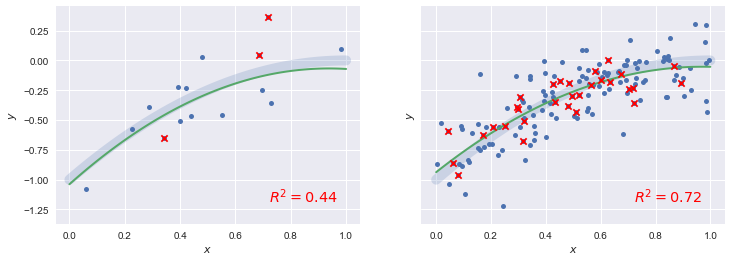

In [12]:
def train_test_split(X, y, degree, test_fraction=0.2, ax=None, seed=123):
    gen = np.random.RandomState(seed=seed)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=test_fraction, random_state=gen)
    train_fit = poly_fit(X_train, y_train, degree)
    plotXy(X, y, ax, train_fit)
    test_R2 = train_fit.score(X_test.reshape(-1, 1), y_test)
    ax.scatter(X_test, y_test, marker='x', color='r', s=40, zorder=10)
    ax.text(0.7, 0.1, '$R^2={:.2f}$'.format(test_R2), transform=ax.transAxes, fontsize='x-large', color='r')

_, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
train_test_split(Xa, ya, 2, ax=ax[0])
train_test_split(Xb, yb, 2, ax=ax[1])

There is no rigorous procedure for setting an optimum test fraction, and anything between 0.1 and 0.5 would be reasonable (and the sklearn default is 0.25).  A larger test fraction improves the reliability of the test metric but decreases the reliability of the model being tested.  As always, more data always helps and reduces your sensitivity to the training fraction.

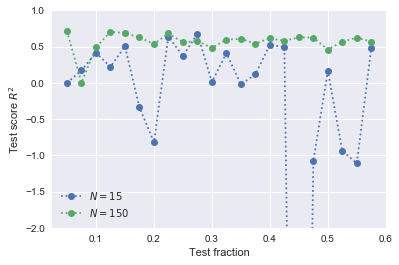

In [13]:
def test_fraction_scan(degree=2, seed=123):
    gen = np.random.RandomState(seed=seed)
    test_fractions = np.arange(0.05, 0.6, 0.025)
    R2 = np.empty((2, len(test_fractions)))
    for i, test_fraction in enumerate(test_fractions):
        for j, (X, y) in enumerate(((Xa, ya), (Xb, yb))):
            X_train, X_test, y_train, y_test = model_selection.train_test_split(
                X, y, test_size=test_fraction, random_state=gen)
            fit = poly_fit(X_train, y_train, degree)
            R2[j, i] = fit.score(X_test.reshape(-1, 1), y_test)
    plt.plot(test_fractions, R2[0], 'o:', label='$N = {}$'.format(len(ya)))
    plt.plot(test_fractions, R2[1], 'o:', label='$N = {}$'.format(len(yb)))
    plt.xlabel('Test fraction')
    plt.ylabel('Test score $R^2$')
    plt.ylim(-2, 1)
    plt.legend()
    
test_fraction_scan()

### K-Folding

Cross validation goes beyond a simple train-test split by repeating the split multiple times and combining the (correlated) results. There are different strategies for picking the different splits, but [K-folding](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) is a good all-around choice:
 - Specify the number $k$ of splits (folds) to use.
 - The data is split into $k$ (almost) equal independent subsets.
 - Each subset is used for testing once, with the remaining subsets used for training.
 
The result is $k$ different train-test splits using a test fraction $1/k$.  For example, with $N=10$ samples and $k=3$ folds, the subsets are:

In [14]:
kfold = model_selection.KFold(n_splits=3)
[tuple(split[1]) for split in kfold.split(range(10))]

[(0, 1, 2, 3), (4, 5, 6), (7, 8, 9)]

The [cross_validate](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function automates the k-folding and scoring process, and outputs both train and test $R^2$ scores, as well as CPU times, for each split:

In [15]:
def cross_validate(X, y, degree, n_splits):
    model = pipeline.Pipeline([
        ('poly', preprocessing.PolynomialFeatures(degree=degree)),
        ('linear', linear_model.LinearRegression(fit_intercept=True))])
    kfold = model_selection.KFold(n_splits=n_splits)
    scores = model_selection.cross_validate(
        model, X.reshape(-1, 1), y, cv=kfold, return_train_score=True)
    index = [tuple(split[1]) for split in kfold.split(X.reshape(-1, 1))]
    return pd.DataFrame(scores, index=index)

In [16]:
cross_validate(Xa, ya, degree=2, n_splits=3)

,fit_time,score_time,test_score,train_score
"(0, 1, 2, 3, 4)",0.001424,0.000862,0.404038,0.731105
"(5, 6, 7, 8, 9)",0.001126,0.000506,-2.232860,0.632223
"(10, 11, 12, 13, 14)",0.000671,0.000285,-0.352504,0.518438


With enough data, you can use a large number of K-folds but remember that they are highly correlated so you are not increasing the useful information as much as you might think. The sklearn default number of splits is 3.

In [17]:
cross_validate(Xb, yb, degree=2, n_splits=15)

,fit_time,score_time,test_score,train_score
"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",0.001362,0.000691,0.574221,0.613270
"(10, 11, 12, 13, 14, 15, 16, 17, 18, 19)",0.000704,0.000364,0.644016,0.608664
"(20, 21, 22, 23, 24, 25, 26, 27, 28, 29)",0.000647,0.000292,0.559857,0.614704
"(30, 31, 32, 33, 34, 35, 36, 37, 38, 39)",0.000498,0.000270,0.382087,0.619587
"(40, 41, 42, 43, 44, 45, 46, 47, 48, 49)",0.000484,0.000267,0.741344,0.601154
"(50, 51, 52, 53, 54, 55, 56, 57, 58, 59)",0.000481,0.000274,0.415899,0.625590
"(60, 61, 62, 63, 64, 65, 66, 67, 68, 69)",0.000508,0.000270,0.675124,0.601310
"(70, 71, 72, 73, 74, 75, 76, 77, 78, 79)",0.000549,0.000394,0.745460,0.599734
"(80, 81, 82, 83, 84, 85, 86, 87, 88, 89)",0.000566,0.000276,0.366792,0.618551
"(90, 91, 92, 93, 94, 95, 96, 97, 98, 99)",0.000503,0.000372,0.498276,0.614549


### Hyperparameter Grid Search

The [GridSearchCV]() function puts all the pieces together to scan a grid of one or more hyperparameters for a family of models.  For example, the polynomial degree $P$ corresponds to a pipeline `poly__degree` parameter, which we vary from 0 to 5 below. The full output from `GridSearchCV` is detailed but unwieldy so we use the MLS `grid_search_summary()` function to create a summary table and plot:

In [18]:
def compare_models(X, y, max_degree=5, n_splits=3, seed=123):
    hyper_grid = {'poly__degree': range(max_degree + 1)}
    hyper_model = pipeline.Pipeline([
        ('poly', preprocessing.PolynomialFeatures()),
        ('linear', linear_model.LinearRegression(fit_intercept=True))])
    kfold = model_selection.KFold(n_splits=n_splits)
    cv = model_selection.GridSearchCV(hyper_model, hyper_grid, cv=kfold, return_train_score=True)
    cv.fit(X.reshape(-1, 1), y)
    return cv_summary(cv)

With a small dataset, a polynomial fit is very prone to overfitting and the training score continues to rise as $P$ increases.  However, only the $P=1$ and $P=2$ models look at all promising on the test data, but are still worse than guessing the average $y$ value (which always has $R^2=0$):

,mean_test,mean_train,poly__degree,split0_test,split0_train,split1_test,split1_train,split2_test,split2_train,std_test,std_train
1,-0.727,0.627,2,0.404,0.731,-2.233,0.632,-0.353,0.518,1.109,0.087
2,-1.049,0.577,1,0.474,0.621,-2.819,0.628,-0.801,0.481,1.356,0.068
3,-3.608,0.000,0,-0.048,0.000,-7.549,0.000,-3.226,0.000,3.074,0.000
4,-11.589,0.732,4,-1.743,0.857,-5.019,0.714,-28.006,0.625,11.685,0.095
5,-17.166,0.656,3,0.408,0.740,-51.581,0.708,-0.324,0.518,24.337,0.098
6,-158.538,0.787,5,-0.837,0.895,-316.856,0.716,-157.921,0.749,129.015,0.077


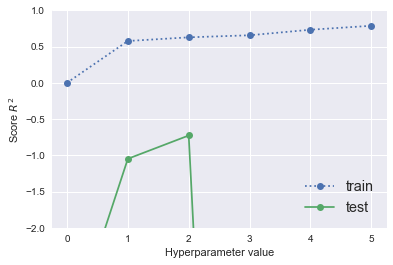

In [19]:
compare_models(Xa, ya)

With a larger dataset, the training score is stable over a wide range of $P\ge 1$ and the test score decreases very slowly. You could make a case for either $P=1$ (less overfitting) or $P=2$ (better test score) from the graph below:

,mean_test,mean_train,poly__degree,split0_test,split0_train,split1_test,split1_train,split2_test,split2_train,std_test,std_train
1,0.567,0.620,2,0.593,0.610,0.600,0.611,0.509,0.638,0.041,0.013
2,0.555,0.623,3,0.563,0.619,0.590,0.612,0.512,0.639,0.032,0.011
3,0.537,0.567,1,0.607,0.536,0.590,0.540,0.415,0.625,0.087,0.041
4,0.499,0.640,4,0.575,0.620,0.584,0.612,0.337,0.688,0.114,0.034
5,0.497,0.642,5,0.569,0.623,0.586,0.612,0.336,0.689,0.114,0.034
6,-0.014,0.000,0,-0.017,0.000,-0.023,0.000,-0.001,0.000,0.009,0.000


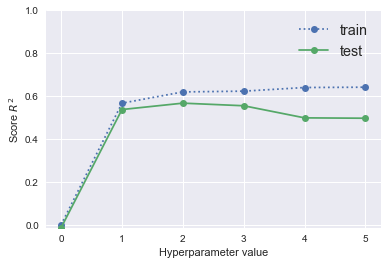

In [20]:
compare_models(Xb, yb)

### Comparison with the Bayesian Evidence

The function below estimates the Bayesian evidence for the data $D=(X,y)$ given a polynomial model of degree $P$, using the same MCMC techniques we saw earlier. The evidence calculation requires an additional ingredient that we never specified for cross validation: a prior on the $P + 1$ polynomial coefficients, which has a similar effect to a regularization term in an sklearn linear regression.  We adopt a Gaussian prior on each coefficient with the same scale, chosen to be large enough that the likelihood will dominate the posterior.

In [21]:
def calculate_evidence(Xdata, ydata, degree, sigma_y=sigma_y, coef_sigma=10., n_mc=5000,
                       n_grid=50, grid_fraction=0.1, seed=123):
    # Use sklearn fit to initialize MCMC chains.
    fit = poly_fit(Xdata, ydata, degree).steps[1][1]
    coef_init = fit.coef_.astype(np.float32)
    if degree > 0:
        coef_init = np.insert(coef_init, 0, fit.intercept_)
    print('Best fit coefficients:', np.round(coef_init, 3))
    P = len(coef_init)
    # Build the graph for this inference.
    graph = tf.Graph()
    with graph.as_default():
        # Build the inference model.
        coef = ed.models.Normal(loc=0., scale=tf.fill((P,), coef_sigma))
        X = tf.placeholder(tf.float32)
        XP = [ X ** p for p in range(degree + 1) ]
        XX = tf.stack(XP, axis=1)
        y_true = tf.reshape(tf.matmul(XX, tf.reshape(coef, [-1, 1])), [-1])
        y = ed.models.Normal(loc=y_true, scale=sigma_y)
        # Prepare for MCMC sampling.
        mc_coef = ed.models.Empirical(
            params=tf.Variable(tf.reshape(tf.tile(coef_init, (n_mc,)), (n_mc, P))))
        # Prepare to tabulate log_likelihood + log_prior on a coefficient grid.
        coef_in = tf.placeholder(tf.float32)
        y_in = tf.placeholder(tf.float32)
        y_true_out = tf.transpose(tf.matmul(XX, tf.transpose(coef_in)))
        y_out = ed.models.Normal(loc=y_true_out, scale=sigma_y)
        log_likelihood = tf.reduce_sum(y_out.log_prob(y_in), axis=-1)
        coef_out = ed.models.Normal(loc=0., scale=tf.fill(tf.shape(coef_in), coef_sigma))
        log_prior = tf.reduce_sum(coef_out.log_prob(coef_in), axis=-1)
        log_numerator = log_likelihood + log_prior

    with tf.Session(graph=graph) as session:
        tf.set_random_seed(seed)
        # Run the inference using HMC to generate samples.
        inference = ed.HMC({coef: mc_coef}, data={X: Xdata, y: ydata})
        inference.run(step_size=0.02, n_steps=50)
        ##inference.run(step_size=0.01, n_steps=5)
        coef_samples = session.run(mc_coef.params)
        # Build a parameter grid for estimating the evidence.
        coef_grid = create_param_grid(coef_samples, n_grid=n_grid)
        # Evaluate log(likelihood) + log(prior) on the parameter grid.
        log_numerator_grid = session.run(
            log_numerator, feed_dict={X: Xdata, y_in: ydata, coef_in: coef_grid})
        
    #sns.pairplot(pd.DataFrame(coef_samples))
    #plt.show()    
    return estimate_log_evidence(coef_samples, coef_grid, log_numerator_grid, grid_fraction=grid_fraction)

Best fit coefficients: [-0.31]
5000/5000 [100%] ██████████████████████████████ Elapsed: 24s | Acceptance Rate: 0.994


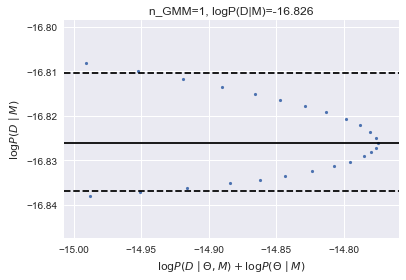

In [22]:
log_Ea_P0 = calculate_evidence(Xa, ya, 0, grid_fraction=0.5)

Best fit coefficients: [-0.31799999]
5000/5000 [100%] ██████████████████████████████ Elapsed: 25s | Acceptance Rate: 0.991


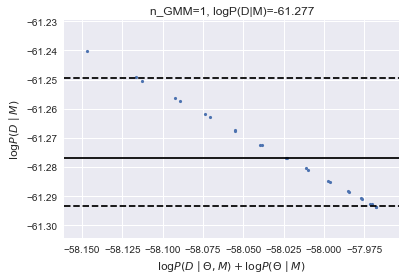

In [23]:
log_Eb_P0 = calculate_evidence(Xb, yb, 0, grid_fraction=0.5)

Best fit coefficients: [-0.87699997  1.14699996]
5000/5000 [100%] ██████████████████████████████ Elapsed: 26s | Acceptance Rate: 0.999


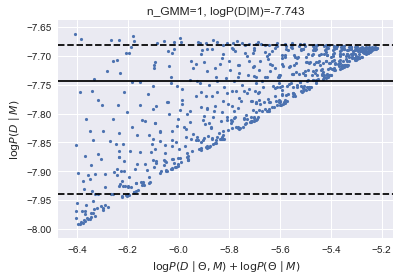

In [24]:
log_Ea_P1 = calculate_evidence(Xa, ya, 1, grid_fraction=0.3)

Best fit coefficients: [-0.74699998  0.84500003]
5000/5000 [100%] ██████████████████████████████ Elapsed: 25s | Acceptance Rate: 0.839


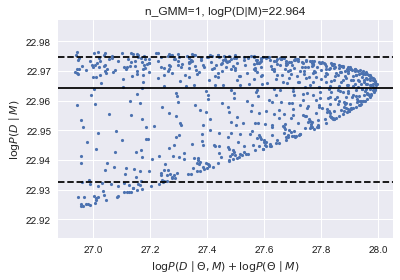

In [25]:
log_Eb_P1 = calculate_evidence(Xb, yb, 1, grid_fraction=0.3)

Best fit coefficients: [-1.13800001  2.39599991 -1.20200002]
5000/5000 [100%] ██████████████████████████████ Elapsed: 23s | Acceptance Rate: 0.990


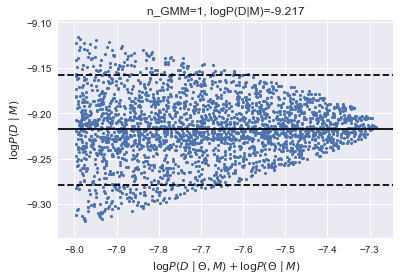

In [26]:
log_Ea_P2 = calculate_evidence(Xa, ya, 2, grid_fraction=0.02)

Best fit coefficients: [-0.92500001  1.78699994 -0.92500001]
5000/5000 [100%] ██████████████████████████████ Elapsed: 24s | Acceptance Rate: 0.856


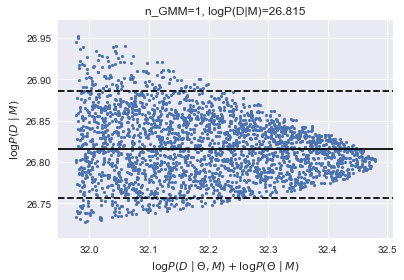

In [27]:
log_Eb_P2 = calculate_evidence(Xb, yb, 2, grid_fraction=0.02)

Best fit coefficients: [-1.24000001  3.37700009 -3.49499989  1.48000002]
5000/5000 [100%] ██████████████████████████████ Elapsed: 24s | Acceptance Rate: 0.981


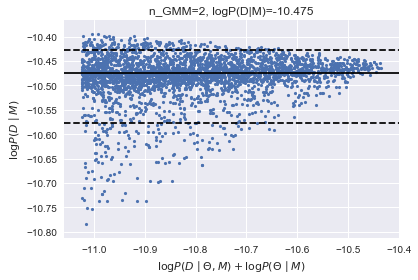

In [28]:
log_Ea_P3 = calculate_evidence(Xa, ya, 3, grid_fraction=0.0005)

Best fit coefficients: [-0.89200002  1.44000006 -0.097      -0.54000002]
5000/5000 [100%] ██████████████████████████████ Elapsed: 25s | Acceptance Rate: 0.805


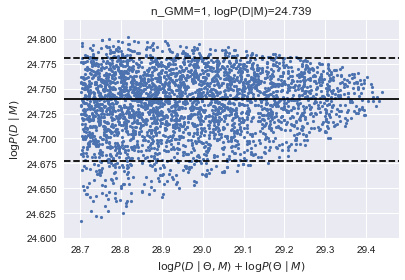

In [29]:
log_Eb_P3 = calculate_evidence(Xb, yb, 3, grid_fraction=0.0005)

Summarize these estimated log evidence values, $\log P(D\mid M)$, for the four models considered, P0-3:

In [30]:
results = pd.DataFrame({
    'P0': [log_Ea_P0, log_Eb_P0], 'P1': [log_Ea_P1, log_Eb_P1],
    'P2': [log_Ea_P2, log_Eb_P2], 'P3': [log_Ea_P3, log_Eb_P3]},
    index=('N=15', 'N=150'))
results.round(2)

,P0,P1,P2,P3
N=15,-16.83,-7.74,-9.22,-10.47
N=150,-61.28,22.96,26.82,24.74


**EXERCISE:** Use the table of $\log P(D\mid M)$ values above to answer the following questions:
 - Which model best explains the $N=15$ dataset?
 - Which model best explains the $N=150$ dataset?
 - Which pairs of models have a Bayes' factor $> 100$, indicating "decisive evidence" favoring one model over the other?
 - Does "decisive evidence" that favors one model over another indicate that the favored model is correct?
 - Are the model comparisons based on evidence substantially different from those based on cross validation in this example?

The $N=15$ dataset is best explained by the P1 model (since it has the maximum value in the first row of the table).

The $N=150$ dataset is best explained by the P2 model (since it has the maximum value in the first row of the table).

A Bayes' factor $> 100$ corresponds to a difference in $\log P(D\mid M)$ of $\log 100 \simeq 4.6$.

Here is a table showing which model pairs pass this test for $N=15$:

In [31]:
row = results.iloc[0].values
print(np.exp(row - row.reshape(-1, 1)) > 100)

[[False  True  True  True]
 [False False False False]
 [False False False False]
 [False False False False]]


And for $N=150$:

In [32]:
row = results.iloc[1].values
print(np.exp(row - row.reshape(-1, 1)) > 100)

[[False  True  True  True]
 [False False False False]
 [False False False False]
 [False False False False]]


We find that, in both cases, the P1, P2, and P3 models are all "decisively favored" over P0 as explanations for the data.

The Bayes' factor is calculated for a pair of models, without considering the range of all possible models. A high value can either indicate that one model of the pair is particularly good or that the other model is particularly bad (or some combination of these). In this example, P0 is particularly bad. In general, the Bayes' factor compares models relative to each other, but does not offer any absolute measure of how well either model explains the data.

These evidence-based model comparisons are broadly consistent with the earlier cross-validation comparisons, but with some differences in the details. The advantages of using evidence are clearer for the smaller dataset, where the cross validation results are difficult to interpret and priors have more influence. Ideally, you should use both methods and compare.